In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import re
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder

from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import cross_val_score
from sklearn import metrics
from sklearn.metrics import precision_score, recall_score, classification_report, accuracy_score, f1_score

from imblearn.over_sampling import RandomOverSampler

# Contents

1. Exploring Data

2. Data preprocessing
* Data Cleaning
* Tokenization
* Removal of stopwords
* Stemming

4. Vectorisation using TF-IDF

3. Model Building: 4 Models used:
* Naive Bayes
* Random Forest
* KNeighbors
* SVM


4. Model Evaluation 
* Classification Reports
* Evaluation Metrics

In [2]:
#Dataset
data=pd.read_csv("/kaggle/input/sms-spam-collection-dataset/spam.csv", encoding="latin-1")
data

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN
...,...,...,...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...,NaN,NaN,NaN
5568,ham,Will Ì_ b going to esplanade fr home?,NaN,NaN,NaN
5569,ham,"Pity, * was in mood for that. So...any other s...",NaN,NaN,NaN
5570,ham,The guy did some bitching but I acted like i'd...,NaN,NaN,NaN


# **Exploring Data**

In [3]:
data.info()
data.columns

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   v1          5572 non-null   object
 1   v2          5572 non-null   object
 2   Unnamed: 2  50 non-null     object
 3   Unnamed: 3  12 non-null     object
 4   Unnamed: 4  6 non-null      object
dtypes: object(5)
memory usage: 217.8+ KB


Index(['v1', 'v2', 'Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], dtype='object')

In [4]:
#Drop irrelevant columns and rename columns
data.drop(['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'],axis=1, inplace=True)
data.rename(columns={'v1':'Target','v2':'Text'}, inplace=True)

In [5]:
data.head()

,Target,Text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [6]:
data.groupby("Target").describe()

Text                                                               
       count unique                                                top freq
Target                                                                     
ham     4825   4516                             Sorry, I'll call later   30
spam     747    653  Please call our customer service representativ...    4

Text(0, 0.5, 'Count')

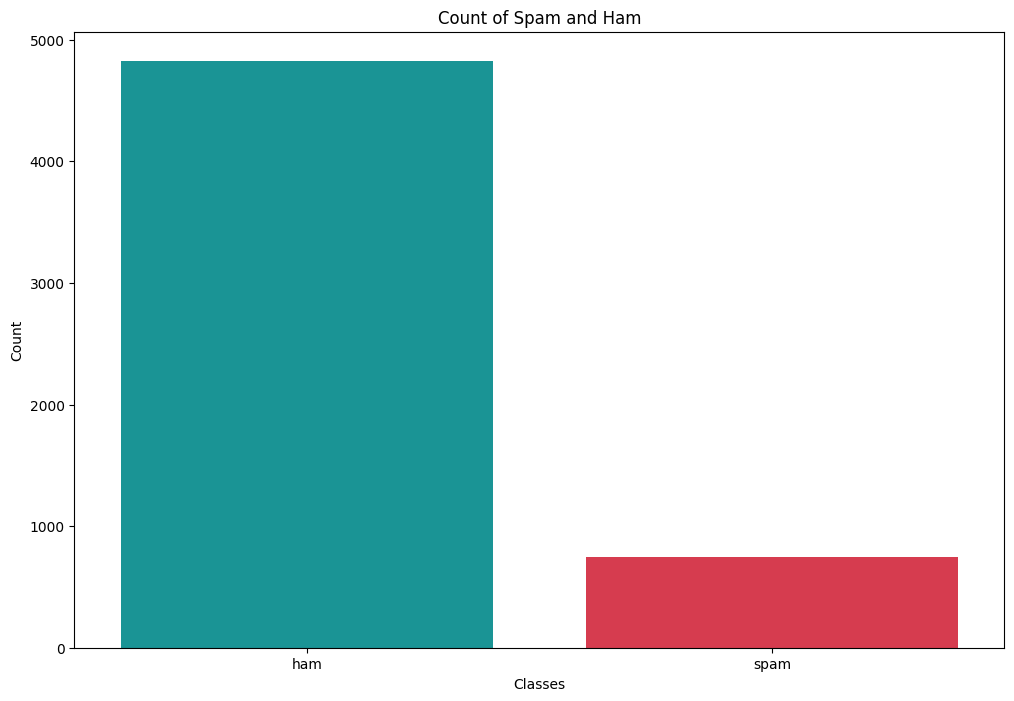

In [7]:
#palette
cols=["#05A8AA","#EF233C"]
plt.figure(figsize=(12,8))
fg=sns.countplot(x=data["Target"], palette=cols)
fg.set_title("Count of Spam and Ham")
fg.set_xlabel("Classes")
fg.set_ylabel("Count")

In [8]:
data["Text_Length"]=data["Text"].apply(len)

In [9]:
data.head()

,Target,Text,Text_Length
0,ham,"Go until jurong point, crazy.. Available only ...",111
1,ham,Ok lar... Joking wif u oni...,29
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,ham,U dun say so early hor... U c already then say...,49
4,ham,"Nah I don't think he goes to usf, he lives aro...",61


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-l

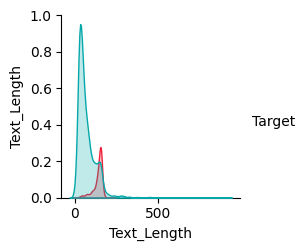

In [10]:
sns.pairplot(data=data,hue='Target', palette=cols)


Lengthy messages are more likely to be ham.

<Axes: >

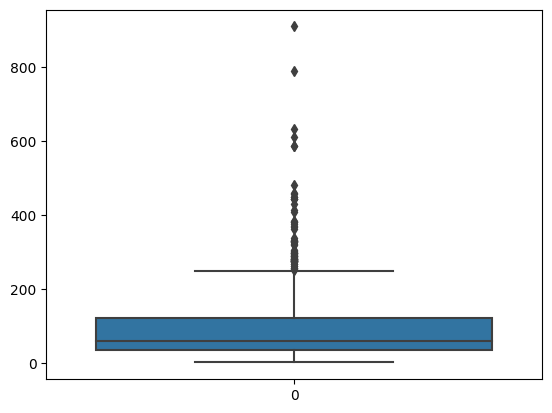

In [11]:
sns.boxplot(data["Text_Length"])

In [12]:
print(data[data["Text_Length"]>450].count())

Target         9
Text           9
Text_Length    9
dtype: int64


In [13]:
#remove outliers
data=data[data["Text_Length"]<450]

# **Data Preprocessing**
**1. Data Cleaning**
* Extract only the alphabetic characters(to remove punctuation and numbers)
* Convert all the characters into lowercase.

In [14]:
print(data["Text"][:10])

0    Go until jurong point, crazy.. Available only ...
1                        Ok lar... Joking wif u oni...
2    Free entry in 2 a wkly comp to win FA Cup fina...
3    U dun say so early hor... U c already then say...
4    Nah I don't think he goes to usf, he lives aro...
5    FreeMsg Hey there darling it's been 3 week's n...
6    Even my brother is not like to speak with me. ...
7    As per your request 'Melle Melle (Oru Minnamin...
8    WINNER!! As a valued network customer you have...
9    Had your mobile 11 months or more? U R entitle...
Name: Text, dtype: object


In [15]:
def clean(text):
    sms= re.sub('[^a-zA-Z]', " ", text)
    sms=sms.lower()
    
    #remove extra whitespaces
    sms= sms.split()
    sms= ' '.join(sms)
    return sms

data["Cleaned_text"]=data["Text"].apply(clean)
    

/tmp/ipykernel_35/3128674265.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["Cleaned_text"]=data["Text"].apply(clean)


In [16]:
print(data["Cleaned_text"][:10])

0    go until jurong point crazy available only in ...
1                              ok lar joking wif u oni
2    free entry in a wkly comp to win fa cup final ...
3          u dun say so early hor u c already then say
4    nah i don t think he goes to usf he lives arou...
5    freemsg hey there darling it s been week s now...
6    even my brother is not like to speak with me t...
7    as per your request melle melle oru minnaminun...
8    winner as a valued network customer you have b...
9    had your mobile months or more u r entitled to...
Name: Cleaned_text, dtype: object




**2. Tokenization**

Tokenization is breaking complex data into smaller units called tokens. It can be done by splitting paragraphs into sentences and sentences into words.

In [17]:
data["Tokenized_text"]=data.apply(lambda row: nltk.word_tokenize(row["Cleaned_text"]), axis=1)

/tmp/ipykernel_35/2143718016.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["Tokenized_text"]=data.apply(lambda row: nltk.word_tokenize(row["Cleaned_text"]), axis=1)


In [18]:
print(data["Tokenized_text"][:10])

0    [go, until, jurong, point, crazy, available, o...
1                       [ok, lar, joking, wif, u, oni]
2    [free, entry, in, a, wkly, comp, to, win, fa, ...
3    [u, dun, say, so, early, hor, u, c, already, t...
4    [nah, i, don, t, think, he, goes, to, usf, he,...
5    [freemsg, hey, there, darling, it, s, been, we...
6    [even, my, brother, is, not, like, to, speak, ...
7    [as, per, your, request, melle, melle, oru, mi...
8    [winner, as, a, valued, network, customer, you...
9    [had, your, mobile, months, or, more, u, r, en...
Name: Tokenized_text, dtype: object


**3. Remove Stopwords**

Stopwords are frequently occurring words(such as few, is, an, etc). These words hold meaning in sentence structure, but do not contribute much to language processing in NLP. 

In [19]:
def remove_stopwords(text):
    stop_words=set(stopwords.words("english"))
    filtered_text = [word for word in text if word not in stop_words]
    return filtered_text

data["Nostopword_text"] = data["Tokenized_text"].apply(remove_stopwords)

/tmp/ipykernel_35/1777826254.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["Nostopword_text"] = data["Tokenized_text"].apply(remove_stopwords)


In [20]:
print(data["Nostopword_text"][:10])

0    [go, jurong, point, crazy, available, bugis, n...
1                       [ok, lar, joking, wif, u, oni]
2    [free, entry, wkly, comp, win, fa, cup, final,...
3        [u, dun, say, early, hor, u, c, already, say]
4       [nah, think, goes, usf, lives, around, though]
5    [freemsg, hey, darling, week, word, back, like...
6    [even, brother, like, speak, treat, like, aids...
7    [per, request, melle, melle, oru, minnaminungi...
8    [winner, valued, network, customer, selected, ...
9    [mobile, months, u, r, entitled, update, lates...
Name: Nostopword_text, dtype: object


**4. Stemming**

The process of reducing words to their root or base form, typically by removing suffixes or prefixes, with the aim of capturing the core meaning of words.

In [21]:
nltk.download('wordnet')

[nltk_data] Error loading wordnet: <urlopen error [Errno -3] Temporary
[nltk_data]     failure in name resolution>


False

In [22]:
stemmer = PorterStemmer()
def stem_word(text):
    stems = [stemmer.stem(word) for word in text]
    return stems
data["Stemmed_text"] = data["Nostopword_text"].apply(stem_word)

/tmp/ipykernel_35/2232693154.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["Stemmed_text"] = data["Nostopword_text"].apply(stem_word)


In [23]:
print(data["Stemmed_text"][:10])

0    [go, jurong, point, crazi, avail, bugi, n, gre...
1                         [ok, lar, joke, wif, u, oni]
2    [free, entri, wkli, comp, win, fa, cup, final,...
3        [u, dun, say, earli, hor, u, c, alreadi, say]
4         [nah, think, goe, usf, live, around, though]
5    [freemsg, hey, darl, week, word, back, like, f...
6    [even, brother, like, speak, treat, like, aid,...
7    [per, request, mell, mell, oru, minnaminungint...
8    [winner, valu, network, custom, select, receiv...
9    [mobil, month, u, r, entitl, updat, latest, co...
Name: Stemmed_text, dtype: object


# Vectorization

TF-IDF in NLP stands for Term Frequency – Inverse document frequency. In NLP cleaned data needs to be converted into a numerical format where each word is represented by a matrix. This is also known as word embedding or Word vectorization.

Steps in the Vectorizing:
* Creating a corpus of lemmatized text
* Converting the corpus in vector form
* Label Encoding the classes in Target


In [24]:
corpus= []
for i in data["Stemmed_text"]:
    msg = ' '.join([row for row in i])
    corpus.append(msg)
    
corpus[:5]

['go jurong point crazi avail bugi n great world la e buffet cine got amor wat',
 'ok lar joke wif u oni',
 'free entri wkli comp win fa cup final tkt st may text fa receiv entri question std txt rate c appli',
 'u dun say earli hor u c alreadi say',
 'nah think goe usf live around though']

In [25]:
tfidf = TfidfVectorizer()
X = tfidf.fit_transform(corpus).toarray()
X.dtype

dtype('float64')

In [26]:
label_encoder = LabelEncoder()
data["Target"] = label_encoder.fit_transform(data["Target"])

/tmp/ipykernel_35/275600629.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["Target"] = label_encoder.fit_transform(data["Target"])


# Class Imbalance Handling

To perform oversampling, undersampling, or other balancing techniques to address class imbalance.

In [27]:
y = data["Target"] 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=11)


In [28]:
oversampler=RandomOverSampler(random_state=11)
X_train, y_train = oversampler.fit_resample(X_train, y_train)

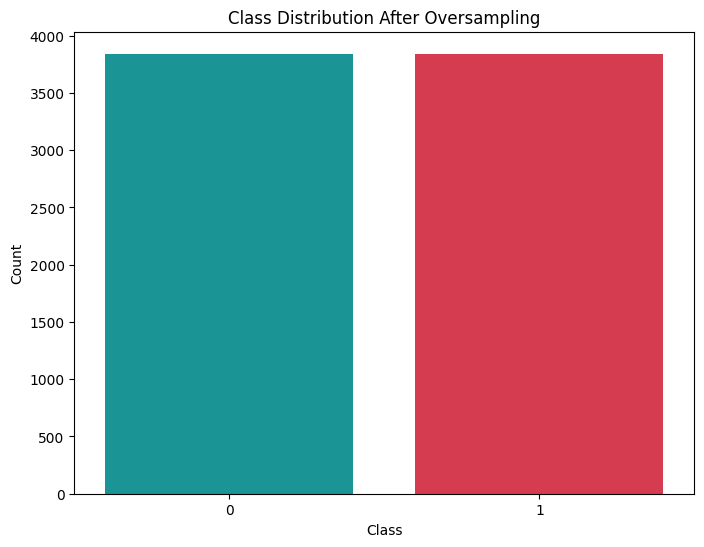

In [29]:
resampled_df = pd.DataFrame({'Target': y_train})

plt.figure(figsize=(8, 6))
sns.countplot(x='Target', data=resampled_df, palette=cols)
plt.title('Class Distribution After Oversampling')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

# **Model Building**

In [30]:
classifiers = [MultinomialNB(), 
               RandomForestClassifier(),
               KNeighborsClassifier(), 
               SVC()]
for cls in classifiers:
    cls.fit(X_train, y_train)

pipe_dict = {0: "NaiveBayes", 1: "RandomForest", 2: "KNeighbours",3: "SVC"}

In [ ]:
for i, model in enumerate(classifiers):
    cv_score = cross_val_score(model, X_train,y_train,scoring="accuracy", cv=10)
    print("%s: %f " % (pipe_dict[i], cv_score.mean()))

NaiveBayes: 0.980740 
RandomForest: 0.999740 
KNeighbours: 0.986728 


# Model Evaluation

In [ ]:
accuracy_list = []
precision_list = []
recall_list = []
f1_list = []
sensitivity_list = []
specificity_list = []
fpr_list = []
fnr_list = []
npv_list = []
fdr_list = []
mcc_list = []

for cls in classifiers:
    
    y_pred = cls.predict(X_test)
    
    # Confusion Matrix
    cm = metrics.confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title(f'Confusion Matrix of {cls}')
    plt.show()
    
    
    print(classification_report(y_test, y_pred))
    
    
    tn, fp, fn, tp = cm.ravel()
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    precision = tp / (tp + fp)
    recall = tp / (fn + tp)
    f1 = 2 * (precision * recall) / (precision + recall)
    sensitivity = tp / (fn + tp)
    specificity = tn / (tn + fp)
    fpr = fp / (tn + fp)
    fnr = fn / (fn + tp)
    npv = tn / (tn + fn)
    fdr = fp / (fp + tp)
    mcc = (tp * tn - fp * fn) / ((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn)) ** 0.5
    
    
    accuracy_list.append(accuracy)
    precision_list.append(precision)
    recall_list.append(recall)
    f1_list.append(f1)
    sensitivity_list.append(sensitivity)
    specificity_list.append(specificity)
    fpr_list.append(fpr)
    fnr_list.append(fnr)
    npv_list.append(npv)
    fdr_list.append(fdr)
    mcc_list.append(mcc)

metrics_df = pd.DataFrame({
    'Model': [pipe_dict[i] for i in range(len(pipe_dict))],
    'Accuracy': accuracy_list,
    'Precision': precision_list,
    'Recall': recall_list,
    'F1-Measure': f1_list,
    'Sensitivity': sensitivity_list,
    'Specificity': specificity_list,
    'FPR': fpr_list,
    'FNR': fnr_list,
    'NPV': npv_list,
    'FDR': fdr_list,
    'MCC': mcc_list
})


In [ ]:
metrics_df.transpose()